 # 1. Colab 환경을 설정하기


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece #내부 단어 분리를 위한 유용한 패키지
!pip install transformers==3.0.2 #인코더 디코더
!pip install torch #딥러닝 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 2.0 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 4.7 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595753 sha256=84d7e7b707c5ed1942624c55e87c0f03ede0c985eb0d867db69dd950c5316a12
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

 # 2. github에서 KoBERT 모델 불러오기

In [3]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-jyop5jn6
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-jyop5jn6
     |████████████████████████████████| 129 kB 4.9 MB/s 
     |████████████████████████████████| 54.7 MB 16 kB/s 
     |████████████████████████████████| 4.5 MB 48.1 MB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:42tcmalloc: large alloc 1147494400 bytes == 0x39ef8000 @  0x7f4b6e760615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 1

In [4]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# 3. 맞춤법 검사기, 문장 나누기 추가 라이브러리 불러오기

In [5]:
# library
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

# 맞춤법 검사기
!pip install git+https://github.com/ssut/py-hanspell.git
from hanspell import spell_checker
# 문장 나누기
!pip install kss
import kss
# 그래프
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-6prowzwn
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-6prowzwn
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=3da13b5ebd54f82ac71a92bca83c095b7e2037787c777ae9878315530ab88778
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wsuc3lm/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.4 MB 7.2 MB/s 
     |████████████████████████████████| 131 kB 66.9 MB/s 
  Created wheel for kss: filename=kss-3.4.3-py3-none-any.whl size=42448068 sha256=93e6e45dd01bb868e602d580f3dd17aed45b376a9a19fbcfbedca2c92dbb7d6c
  Stored in directory: /root/.cache/pip/wheel

In [6]:
#GPU 사용
device = torch.device("cuda:0")

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


 # 4. 데이터셋 불러오기

In [7]:
import pandas as pd
chatbot_data  = pd.read_excel('데이터셋.xlsx')

In [8]:
chatbot_data.sample(n=10)

,sentence,emotion,Unnamed: 2,총 개수,38576
6731,나 이번 시험 망해서 기분이 좋지 않아.친구랑 영화를 보거나 맛있는 걸 먹어.,화남,NaN,NaN,NaN
24410,이번에도 정직원 전환이 안 됐어. 회사는 내가 필요하지 않나 봐.사실 뭐 대단한 회...,불안,NaN,NaN,NaN
32989,내 아들은 항상 남편과만 등산이나 낚시를 가고 나는 따돌리는 것 같아.왜 나랑은 외...,화남,NaN,NaN,NaN
17245,나는 학교에 가서 열심히 공부를 해도 의미가 없는 것 같아서 막막해.차라리 학원에 ...,슬픔,NaN,NaN,NaN
12965,엄마에게 막 대하는 남편 태도에 환멸이 나. 이번엔 엄마 앞에서 대놓고 치매 걸린 ...,슬픔,NaN,NaN,NaN
6559,동기가 실적을 궁금해 했는데 대답을 해주지 않았어.실적을 얘기해주는 게 뭔가 부끄러웠어.,불안,NaN,NaN,NaN
36723,클린디젤이라고 명명한놈 집에 24시간 경유차 시동걸어두자,무감정,NaN,NaN,NaN
28700,당뇨 초기에 가볍게 넘기지 말고 식단 조절을 해야 했어. 지금 와서 너무 후회가 돼...,슬픔,NaN,NaN,NaN
28800,나도 몇 명의 친구들처럼 따돌림을 당할까 봐 두려워.다들 원만하게 잘 지내는 거 같아.,불안,NaN,NaN,NaN
8787,아내가 돈 관리를 하는데 나한테 용돈을 너무 적게 줘서 화나.나도 돈 벌어오는 사람...,화남,NaN,NaN,NaN


In [9]:
chatbot_data.loc[(chatbot_data['emotion'] == "행복"), 'emotion'] = 0  #행복 => 1
chatbot_data.loc[(chatbot_data['emotion'] == "슬픔"), 'emotion'] = 1  #슬픔 => 2
chatbot_data.loc[(chatbot_data['emotion'] == "화남"), 'emotion'] = 2  #분노 => 3
chatbot_data.loc[(chatbot_data['emotion'] == "무감정"), 'emotion'] = 3  #무감정 => 4
chatbot_data.loc[(chatbot_data['emotion'] == "불안"), 'emotion'] = 4  #불안 => 5

In [10]:
data_list = []
for q, label in zip(chatbot_data['sentence'], chatbot_data['emotion'])  :
    data = []   
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [11]:
print(data_list[0])

['건강을 해치는 일등 공신은 스트레스야. 스트레스는 악한 존재야. 스트레스가 만병의 근원인걸.', '1']


In [12]:
print(data_list[6000])

['건강 상태에 당황했어.내 건강이 정말 안 좋아.', '4']


 # 5. 입력 데이터셋 토큰화

In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [14]:
# Setting parameters
max_len = 250
batch_size = 16
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [15]:
# train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [16]:
print(len(dataset_train))
print(len(dataset_test))

30860
7716


In [17]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [18]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, max_len, True, False)

In [19]:
data_train[0]

(array([   2,  993, 7909, 6825, 7078,  517, 7364, 3609,  517, 6570, 7476,
        7811, 3135, 1771, 5439, 5007, 3419, 4074, 6745, 6896, 4207, 7794,
        3609, 1395, 5761, 2086, 2010, 6885, 6855,  517,   54, 1101, 6079,
        7018,  517,   54,  517, 7226, 5340, 6107, 5859, 4368, 4207, 7795,
        2086, 2010, 7086, 4297, 3422, 5895, 6855,  517,   54, 5069, 6825,
        7096, 1514, 6553, 3571, 7828,  881, 3166, 7330, 1458, 2718, 6037,
        7018,  517,   54,    3,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1, 

In [20]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  index = self._next_index()  # may raise StopIteration


# 6. KoBERT 모델 구현

In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes= 5, # 클래스 수 
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [22]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [23]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

 # 7. 학습 시키기

In [24]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1929 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  index = self._next_index()  # may raise StopIteration


epoch 1 batch id 1 loss 1.6142584085464478 train acc 0.1875
epoch 1 batch id 201 loss 1.4401023387908936 train acc 0.30068407960199006
epoch 1 batch id 401 loss 0.8396728038787842 train acc 0.4462281795511222
epoch 1 batch id 601 loss 0.8811506628990173 train acc 0.5427412645590682
epoch 1 batch id 801 loss 0.6001524329185486 train acc 0.5880930087390761
epoch 1 batch id 1001 loss 0.7002519369125366 train acc 0.6166333666333667
epoch 1 batch id 1201 loss 0.7741507291793823 train acc 0.6359804329725229
epoch 1 batch id 1401 loss 0.7315401434898376 train acc 0.6531941470378301
epoch 1 batch id 1601 loss 0.5612984299659729 train acc 0.6636477201748907
epoch 1 batch id 1801 loss 0.8824179172515869 train acc 0.6720918933925597
epoch 1 train acc 0.6770563331605323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 1 test acc 0.7532349896480331


  0%|          | 0/1929 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8284576535224915 train acc 0.75
epoch 2 batch id 201 loss 0.7510977387428284 train acc 0.7605721393034826
epoch 2 batch id 401 loss 0.7864929437637329 train acc 0.7649625935162094
epoch 2 batch id 601 loss 1.1224620342254639 train acc 0.7670549084858569
epoch 2 batch id 801 loss 0.666955828666687 train acc 0.7681803995006242
epoch 2 batch id 1001 loss 0.9167602062225342 train acc 0.7696053946053946
epoch 2 batch id 1201 loss 0.6137205362319946 train acc 0.7726373855120733
epoch 2 batch id 1401 loss 0.4757970869541168 train acc 0.7755174875089222
epoch 2 batch id 1601 loss 0.3412994146347046 train acc 0.7770924422236103
epoch 2 batch id 1801 loss 0.7897130846977234 train acc 0.7774500277623543
epoch 2 train acc 0.7785121824779678


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 2 test acc 0.7719979296066253


  0%|          | 0/1929 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.28547680377960205 train acc 0.875
epoch 3 batch id 201 loss 0.4603910446166992 train acc 0.8112562189054726
epoch 3 batch id 401 loss 0.5141364932060242 train acc 0.8072007481296758
epoch 3 batch id 601 loss 1.2163841724395752 train acc 0.8117720465890182
epoch 3 batch id 801 loss 0.5218119621276855 train acc 0.8141385767790262
epoch 3 batch id 1001 loss 0.5038291811943054 train acc 0.8156218781218781
epoch 3 batch id 1201 loss 0.614978551864624 train acc 0.8187447960033306
epoch 3 batch id 1401 loss 0.4641987383365631 train acc 0.8215560314061384
epoch 3 batch id 1601 loss 0.30779021978378296 train acc 0.8231964397251718
epoch 3 batch id 1801 loss 0.7307277917861938 train acc 0.824229594669628
epoch 3 train acc 0.8257516848107828


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 3 test acc 0.7734213250517599


  0%|          | 0/1929 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.11650674790143967 train acc 1.0
epoch 4 batch id 201 loss 0.411406934261322 train acc 0.8519900497512438
epoch 4 batch id 401 loss 0.3540504276752472 train acc 0.849283042394015
epoch 4 batch id 601 loss 0.9641849994659424 train acc 0.8534733777038269
epoch 4 batch id 801 loss 0.4369598627090454 train acc 0.8554151061173533
epoch 4 batch id 1001 loss 0.5086345672607422 train acc 0.859577922077922
epoch 4 batch id 1201 loss 0.3586277961730957 train acc 0.8625624479600333
epoch 4 batch id 1401 loss 0.43314939737319946 train acc 0.8643825838686653
epoch 4 batch id 1601 loss 0.26059025526046753 train acc 0.8654356652092442
epoch 4 batch id 1801 loss 0.5689390301704407 train acc 0.8677123820099945
epoch 4 train acc 0.8690707620528771


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 4 test acc 0.7784679089026915


  0%|          | 0/1929 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.05168434977531433 train acc 1.0
epoch 5 batch id 201 loss 0.29012277722358704 train acc 0.8970771144278606
epoch 5 batch id 401 loss 0.10735996067523956 train acc 0.8924563591022444
epoch 5 batch id 601 loss 1.0568735599517822 train acc 0.896630615640599
epoch 5 batch id 801 loss 0.3541375994682312 train acc 0.8972378277153558
epoch 5 batch id 1001 loss 0.22573310136795044 train acc 0.8999125874125874
epoch 5 batch id 1201 loss 0.34505969285964966 train acc 0.9010199833472107
epoch 5 batch id 1401 loss 0.4139811098575592 train acc 0.9016773733047823
epoch 5 batch id 1601 loss 0.25209182500839233 train acc 0.9016630231105559
epoch 5 batch id 1801 loss 0.5420085787773132 train acc 0.9024153248195447
epoch 5 train acc 0.9031881804043546


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 5 test acc 0.7748447204968945


In [25]:
torch.save(model, f'./model.pt')

#  8. 테스트

In [26]:
 count = [0]*5

In [27]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("행복이")
                count[0] += 1
            elif np.argmax(logits) == 1:
                test_eval.append("슬픔이")
                count[1] += 1
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
                count[2] += 1
            elif np.argmax(logits) == 3:
                test_eval.append("중립이")
                count[3] += 1
            elif np.argmax(logits) == 4:
                test_eval.append("불안이")
                count[4] += 1

        print("입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

일기 작성: 오늘 서울을 갔다.


오늘 서울을 갔다.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  index = self._next_index()  # may raise StopIteration


입력하신 내용에서 중립이 느껴집니다.


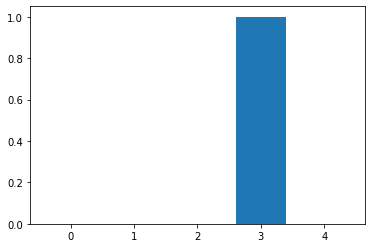



일기 작성: 어떻게 해야할까?
어떻게 해야 할까?
입력하신 내용에서 불안이 느껴집니다.


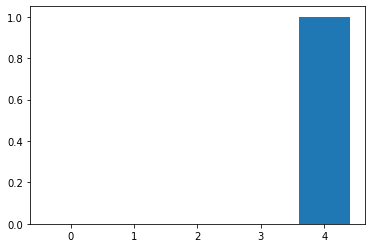



일기 작성: 오늘 인천 공항으로 갔다. 그런데 사람이 너무 많아서 짜증났다. 하필 왜 날짜를 잡아도 이런 날로 잡는거야?
오늘 인천 공항으로 갔다. 그런데 사람이 너무 많아서 짜증 났다. 하필 왜 날짜를 잡아도 이런 날로 잡는 거야?
입력하신 내용에서 중립이 느껴집니다.
입력하신 내용에서 분노가 느껴집니다.
입력하신 내용에서 분노가 느껴집니다.


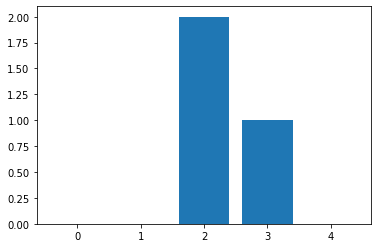



일기 작성: 0


In [28]:
end = 1
while end == 1 :
    sentence = input("일기 작성: ")
    if sentence == "0" :
        break
    spelled_sent = spell_checker.check(sentence)
    hanspell_sent = spelled_sent.checked
    print(hanspell_sent)

    final = kss.split_sentences(hanspell_sent)

    for j in range(len(final)) :
      predict(final[j])

    plt.bar(range(len(count)), count)
    plt.show()
    count = [0 for _ in range(5)]
    print("\n")